In [1]:
from utils import *

In [2]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)

df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [3]:
#Train
train_trans = Transforms()
df_train , y_train = train_trans.modify_data(data = df_train , dur_col = 'duration' , eve_col = 'event' , cuts = 10)
print(f'indices {train_trans.bucket_indices}')

#Val
val_trans = Transforms()
df_val , y_val = val_trans.modify_data(data = df_val , dur_col = 'duration' , eve_col = 'event' , cuts = 10)
# print(f'indices {val_trans.bucket_indices}')

#Test
test_trans = Transforms()
df_test , y_test = test_trans.modify_data(data = df_test , dur_col = 'duration' , eve_col = 'event' , cuts = 10)
# print(f'indices {test_trans.bucket_indices}')

indices [2 2 6 ... 0 5 3]


In [4]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [5]:
# Hyper Params
input_size = x_train.shape[1]
hidden_size = 32
output_size = train_trans.n_bucket_indices
# batch_norm = True
dropout = 0.1
learning_rate = 0.01
num_epochs = 100

# Convert dtypes
dur_idx = torch.Tensor(y_train[0].astype('int'))
events = torch.Tensor(y_train[1].astype('int') )

dur_idx_val = torch.Tensor(y_val[0].astype('int'))
events_val = torch.Tensor(y_val[1].astype('int') )

# Define early stopping parameters
patience = 10
best_loss = float('inf')
counter = 0

# init model
model = MLP(input_size , hidden_size , output_size , dropout_rate = dropout)

# init optim
optimizer = torch.optim.Adam(model.parameters() , lr = learning_rate)

# Create an instance of your custom dataset
dataset = MyDataset(x_train, dur_idx, events)

# Create a data loader for batching and shuffling
batch_size = 256
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [6]:
# Training loop
for epoch in range(num_epochs):
    for batch_id , (cov , dur , eve) in enumerate(dataloader):
        # Prime for training
        model.train()
        # print(f'dimension {cov.shape} , {dur.shape} , {eve.shape}')
        # forward pass
        phi_train = model(torch.Tensor(cov))
        # print(f'phi train dimension {phi_train.shape}')

        # get loss
        loss = nll_logistic_hazard(phi_train , dur , eve)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Prime for evaluation
        model.eval()
        with torch.no_grad():
            phi_val = model(torch.Tensor(x_val))
            val_loss = nll_logistic_hazard(phi_val, dur_idx_val , events_val)
        
        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

        print(f"Epoch {epoch+1}: Training Loss: {loss.item():.4f}, ") 

# turn training off
model.eval()

Epoch 1: Training Loss: 2.7735, 
Epoch 1: Training Loss: 2.7628, 
Epoch 1: Training Loss: 2.5701, 
Epoch 1: Training Loss: 2.5537, 
Epoch 1: Training Loss: 2.6309, 
Epoch 2: Training Loss: 2.3408, 
Epoch 2: Training Loss: 2.4313, 
Epoch 2: Training Loss: 2.4407, 
Epoch 2: Training Loss: 2.3189, 
Epoch 2: Training Loss: 2.1458, 
Epoch 3: Training Loss: 2.2532, 
Epoch 3: Training Loss: 2.0207, 
Epoch 3: Training Loss: 2.1659, 
Epoch 3: Training Loss: 2.1057, 
Epoch 3: Training Loss: 2.0452, 
Epoch 4: Training Loss: 2.0168, 
Epoch 4: Training Loss: 1.8777, 
Epoch 4: Training Loss: 1.8481, 
Epoch 4: Training Loss: 1.7608, 
Epoch 4: Training Loss: 1.9211, 
Epoch 5: Training Loss: 1.6981, 
Epoch 5: Training Loss: 1.6752, 
Epoch 5: Training Loss: 1.6789, 
Epoch 5: Training Loss: 1.7203, 
Epoch 5: Training Loss: 1.5515, 
Epoch 6: Training Loss: 1.5414, 
Epoch 6: Training Loss: 1.5301, 
Epoch 6: Training Loss: 1.5050, 
Epoch 6: Training Loss: 1.5357, 
Epoch 6: Training Loss: 1.4454, 
Epoch 7: T

MLP(
  (network): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [7]:
#testing
hazards = torch.sigmoid(model(torch.Tensor(x_test)))
survival = torch.cumprod(1 - hazards , dim = 1)

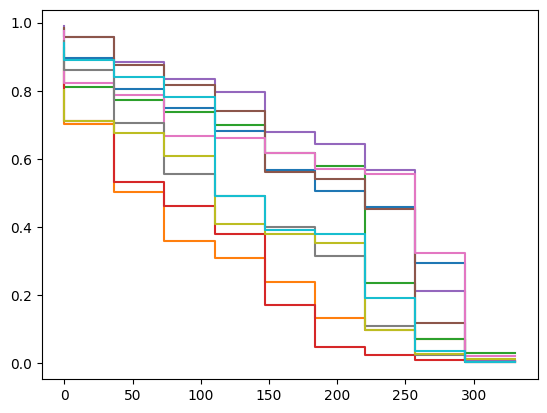

In [16]:
for surv in survival[300:310]:
    plt.step(test_trans.bin_edges , surv.detach().numpy());